In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
import torch
import numpy as np
from loguru import logger
from torch.optim import Adam
import matplotlib.pyplot as plt
from IPython.display import Image

from src.utils import (
    device,
    set_seed,
    eval_policy,
    demo_policy,
    plot_returns,
    save_frames_as_gif
)

plt.ion()

In [3]:
SEED: int = 42
ENVIRONMENT_NAME: str='LunarLander-v2'
ENVIRONMENT_NAME: str='CartPole-v1'

# torch related defaults
DEVICE = device()
torch.set_default_dtype(torch.float32)
print(f"Using device: {DEVICE}")

2024-10-27 00:50:59.145 | INFO     | src.utils:device:51 - Using cuda device.


Using device: cuda


In [5]:
# Use random seeds for reproducibility
set_seed(SEED)

# instantiate the environment
environment = gym.make(ENVIRONMENT_NAME)

# get the state and action dimensions
num_actions = environment.action_space.n
state_dimension = environment.observation_space.shape[0]

2024-10-27 00:51:20.262 | INFO     | src.utils:set_seed:37 - Random seed set as 42.


***

## 1. REINFORCE

In [16]:
from src.networks import Policy
from src.reinforce import train_one_epoch as reinforce_epoch

################################## Hyper-parameters Tuning ##################################

EPOCHS: int = 200
HIDDEN_LAYER: int = 1
HIDDEN_DIMENSION: int = 32
LEARNING_RATE: float = 5e-3

#############################################################################################
with_vime=False
def he_init(layer):
    """He initialization for weights."""
    if isinstance(layer, torch.nn.Linear):
        torch.nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
        layer.bias.data.fill_(0.001)
# Instantiate the policy network
policy = Policy(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION, hidden_layers=HIDDEN_LAYER, with_vime=with_vime
).to(DEVICE)
# policy.apply(he_init)
print(policy)
# Learn the policy
optimizer = Adam(policy.parameters(), LEARNING_RATE)

# Loop for each epoch
mean_returns, std_returns = [], []
for epoch in range(EPOCHS):
    reinforce_epoch(environment, policy, optimizer, with_vime=with_vime)
    
    episode_return_mean, episode_return_std = eval_policy(policy, ENVIRONMENT_NAME)
    mean_returns.append(episode_return_mean)
    std_returns.append(episode_return_std)
    
    logger.info(f'Epoch: {epoch:3d} \t return: {episode_return_mean:.2f}')

    if epoch:
        plot_returns(
            mean_returns, std_returns, method_name=f'reinforce', dynamic=True
            # mean_returns, std_returns, method_name=f'reinforce-{EPOCHS}-{HIDDEN_LAYER}-{HIDDEN_DIMENSION}-{LEARNING_RATE}', dynamic=True
        )

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


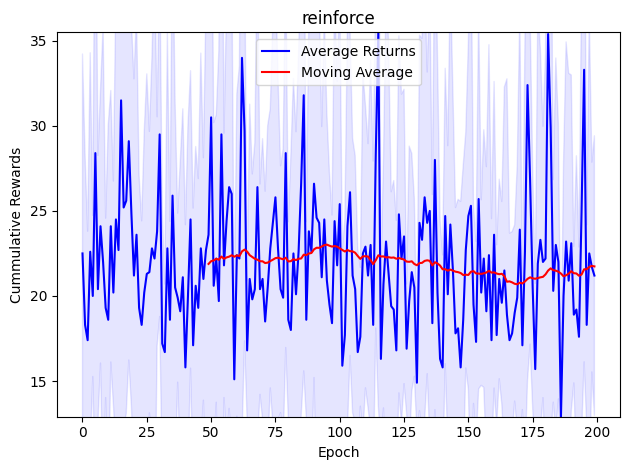

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [17]:
plot_returns(
    mean_returns, std_returns, method_name=f'reinforce'
    # mean_returns, std_returns, method_name=f'reinforce-{EPOCHS}-{HIDDEN_LAYER}-{HIDDEN_DIMENSION}-{LEARNING_RATE}'
)

MovieWriter imagemagick unavailable; using Pillow instead.


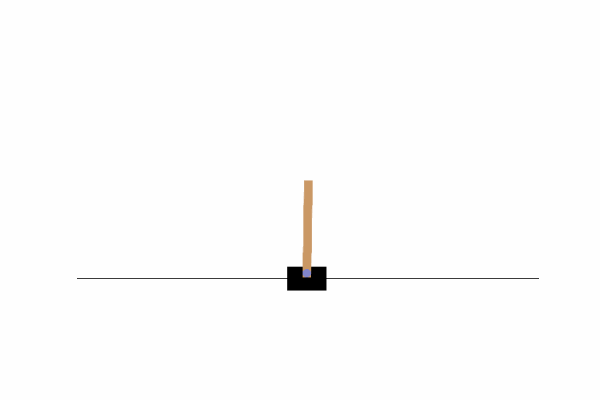

In [18]:
frames = demo_policy(
    policy, ENVIRONMENT_NAME
)
gif_path = save_frames_as_gif(frames, method_name=f'reinforce')
# gif_path = save_frames_as_gif(frames, method_name=f'reinforce-{EPOCHS}-{HIDDEN_LAYER}-{HIDDEN_DIMENSION}-{LEARNING_RATE}')
Image(open(gif_path,'rb').read())

In [7]:
from src.networks import Policy
from src.reinforce import train_one_epoch as reinforce_epoch

################################## Hyper-parameters Tuning ##################################

EPOCHS: int = 200
HIDDEN_LAYER: int = 1
HIDDEN_DIMENSION: int = 32
LEARNING_RATE: float = 5e-3

#############################################################################################
with_vime = True
# Instantiate the policy network
policy_vime = Policy(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION, hidden_layers=HIDDEN_LAYER, with_vime=with_vime, beta=1.0
).to(DEVICE)
# policy.apply(he_init)
# Learn the policy
optimizer_vime = Adam(policy_vime.parameters(), LEARNING_RATE)

# Loop for each epoch
mean_returns_vime, std_returns_vime = [], []
for epoch in range(EPOCHS):
    reinforce_epoch(environment, policy_vime, optimizer_vime, with_vime=with_vime)
    
    episode_return_mean, episode_return_std = eval_policy(policy_vime, ENVIRONMENT_NAME)
    mean_returns_vime.append(episode_return_mean)
    std_returns_vime.append(episode_return_std)
    
    logger.info(f'Epoch: {epoch:3d} \t return: {episode_return_mean:.2f}')

    if epoch:
        plot_returns(
            mean_returns_vime, std_returns_vime, method_name=f'reinforce_vime', dynamic=True
            # mean_returns, std_returns, method_name=f'reinforce-{EPOCHS}-{HIDDEN_LAYER}-{HIDDEN_DIMENSION}-{LEARNING_RATE}', dynamic=True
        )

<Figure size 640x480 with 0 Axes>

In [10]:
for epoch in range(EPOCHS, 500):
    reinforce_epoch(environment, policy_vime, optimizer_vime, with_vime=with_vime)
    
    episode_return_mean, episode_return_std = eval_policy(policy_vime, ENVIRONMENT_NAME)
    mean_returns_vime.append(episode_return_mean)
    std_returns_vime.append(episode_return_std)
    
    logger.info(f'Epoch: {epoch:3d} \t return: {episode_return_mean:.2f}')

    if epoch:
        plot_returns(
            mean_returns_vime, std_returns_vime, method_name=f'reinforce_vime', dynamic=True
            # mean_returns, std_returns, method_name=f'reinforce-{EPOCHS}-{HIDDEN_LAYER}-{HIDDEN_DIMENSION}-{LEARNING_RATE}', dynamic=True
        )

tensor([-0.7036, -0.7036, -0.6828,  ..., -0.6863, -0.6863, -0.6863],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor([36.3210, 36.3210, 36.3210,  ..., 49.1772, 49.1772, 49.1772],
       device='cuda:0')


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

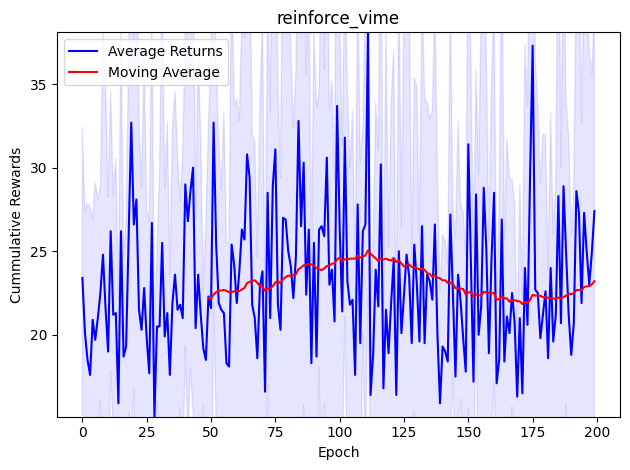

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
plot_returns(
    mean_returns_vime, std_returns_vime, method_name=f'reinforce_vime'
)

MovieWriter imagemagick unavailable; using Pillow instead.


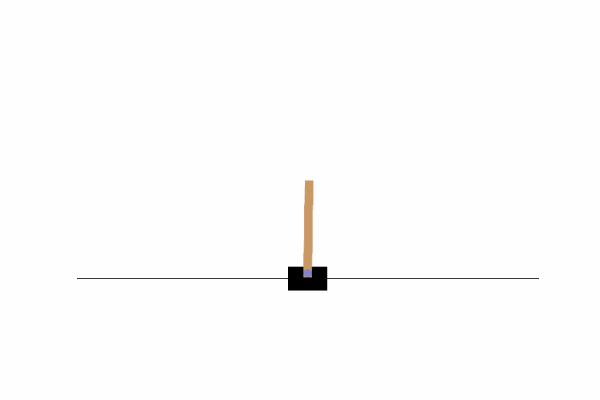

In [9]:
frames = demo_policy(
    policy_vime, ENVIRONMENT_NAME
)
gif_path = save_frames_as_gif(frames, method_name=f'reinforce_vime')
# gif_path = save_frames_as_gif(frames, method_name=f'reinforce-{EPOCHS}-{HIDDEN_LAYER}-{HIDDEN_DIMENSION}-{LEARNING_RATE}')
Image(open(gif_path,'rb').read())

***

## 2. Simple Q-iteration (no experience replay + target network)

In [5]:
from src.networks import ValueFunctionQ
from src.q_iter import train_one_epoch as q_iter_epoch
from src import q_iter
################################## Hyper-parameters Tuning ##################################

EPOCHS: int = 500
HIDDEN_DIMENSION: int = 64
LEARNING_RATE: float = 2e-3
WITH_VIME: bool = True
#############################################################################################

q_iter.eps = q_iter.EPS_START
# Instantiate the state-action value function, Q
Q = ValueFunctionQ(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION, with_vime=WITH_VIME
).to(DEVICE)
# Learn the policy
optimizer = Adam(Q.parameters(), LEARNING_RATE)

mean_returns, std_returns = [], []
for epoch in range(EPOCHS):
    q_iter_epoch(env=environment, Q=Q, optimizer=optimizer, with_vime=WITH_VIME)
    
    episode_return_mean, episode_return_std = eval_policy(Q, ENVIRONMENT_NAME)
    mean_returns.append(episode_return_mean)
    std_returns.append(episode_return_std)
    
    from src.q_iter import eps
    
    logger.info(f'Epoch: {epoch:3d}, \t return: {episode_return_mean:.2f}, \t eps: {eps:.2f}')

    if epoch:
        plot_returns(
            mean_returns, std_returns, method_name='q_iteration_vime', dynamic=True
        )

<Figure size 640x480 with 0 Axes>

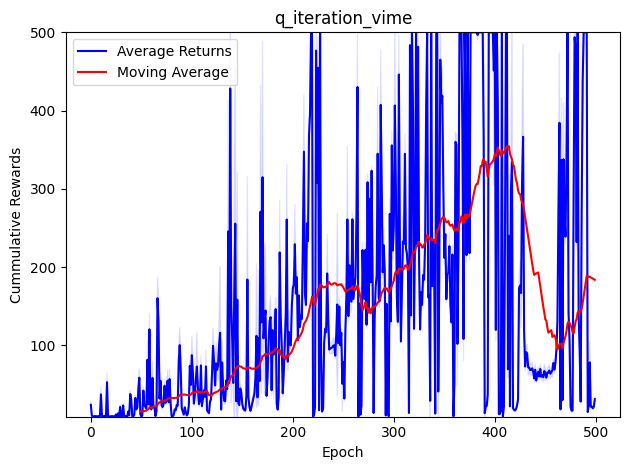

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [6]:
plot_returns(
    mean_returns, std_returns, method_name='q_iteration_vime'
)

/home/cassie/miniforge3/envs/drl1/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
MovieWriter imagemagick unavailable; using Pillow instead.


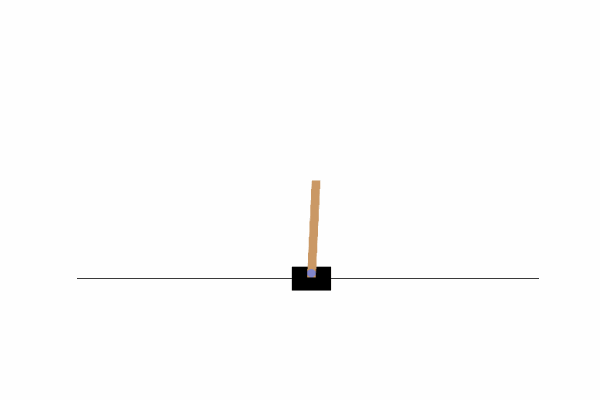

In [11]:
frames = demo_policy(
    Q, ENVIRONMENT_NAME
)
gif_path = save_frames_as_gif(frames, method_name='q_iteration_vime')
Image(open(gif_path,'rb').read())

In [8]:
from src.networks import ValueFunctionQ
from src.q_iter import train_one_epoch as q_iter_epoch
from src import q_iter
################################## Hyper-parameters Tuning ##################################

EPOCHS: int = 500
HIDDEN_DIMENSION: int = 64
LEARNING_RATE: float = 2e-3
WITH_VIME: bool = False
#############################################################################################

q_iter.eps = q_iter.EPS_START
# Instantiate the state-action value function, Q
Q_base = ValueFunctionQ(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION, with_vime=WITH_VIME
).to(DEVICE)
# Learn the policy
optimizer_base = Adam(Q_base.parameters(), LEARNING_RATE)

mean_returns_base, std_returns_base = [], []
for epoch in range(EPOCHS):
    q_iter_epoch(env=environment, Q=Q_base, optimizer=optimizer_base, with_vime=WITH_VIME)
    
    episode_return_mean, episode_return_std = eval_policy(Q_base, ENVIRONMENT_NAME)
    mean_returns_base.append(episode_return_mean)
    std_returns_base.append(episode_return_std)
    
    from src.q_iter import eps
    
    logger.info(f'Epoch: {epoch:3d}, \t return: {episode_return_mean:.2f}, \t eps: {eps:.2f}')

    if epoch:
        plot_returns(
            mean_returns_base, std_returns_base, method_name='q_iteration', dynamic=True
        )

<Figure size 640x480 with 0 Axes>

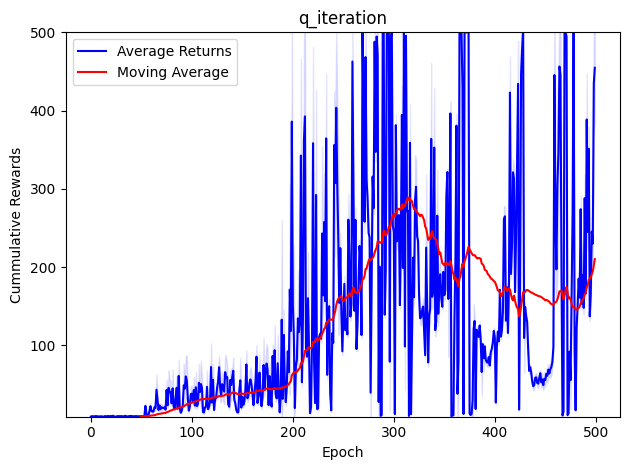

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
plot_returns(
    mean_returns_base, std_returns_base, method_name='q_iteration'
)

/home/cassie/miniforge3/envs/drl1/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
MovieWriter imagemagick unavailable; using Pillow instead.


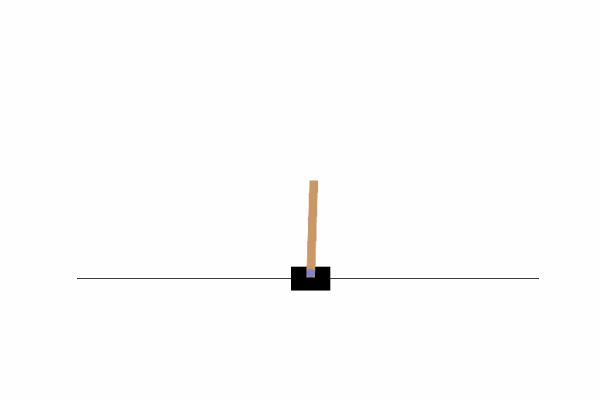

In [10]:
frames = demo_policy(
    Q_base, ENVIRONMENT_NAME
)
gif_path = save_frames_as_gif(frames, method_name='q_iteration')
Image(open(gif_path,'rb').read())

***

## Experience Replay Buffer/Memory

In [25]:
from src.buffer import ReplayBuffer
################################## Hyper-parameters Tuning ##################################

BATCH_SIZE: int = 64
#############################################################################################

# instantiate the memory replay buffer
memory = ReplayBuffer(
    capacity=10_000, batch_size=BATCH_SIZE
)

***

## 3. DQN (Deep Q-learning + experience replay + target network)

In [26]:
from src.networks import ValueFunctionQ
from src.dqn import train_one_epoch as dqn_epoch
from src import dqn
################################## Hyper-parameters Tuning ##################################

EPOCHS: int = 500
HIDDEN_DIMENSION: int = 64
LEARNING_RATE: float = 2e-3

#############################################################################################
dqn.eps = 2.0
dqn.EPS_DECAY = 0.999_95
dqn.EPS_END = 0.1
# instantiate the state-action value function, Q
Q = ValueFunctionQ(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION
).to(DEVICE)
# initialize the target network
target_Q = ValueFunctionQ(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION
).to(DEVICE)

# Learn the policy
optimizer = Adam(Q.parameters(), LEARNING_RATE)

memory.clear()
mean_returns, std_returns = [], []
for epoch in range(EPOCHS):
    
    # copy target network params
    target_Q.load_state_dict(Q.state_dict())

    dqn_epoch(
        env=environment, Q=Q, target_Q=target_Q,
        memory=memory, optimizer=optimizer
    )
    
    episode_return_mean, episode_return_std = eval_policy(Q, ENVIRONMENT_NAME)
    mean_returns.append(episode_return_mean)
    std_returns.append(episode_return_std)

    from src.dqn import eps
    
    logger.info(f'Epoch: {epoch:3d}, \t return: {episode_return_mean:.2f}, \t eps: {eps:.2f}')

    if epoch:
        plot_returns(
            mean_returns, std_returns, method_name='dqn', dynamic=True
        )

<Figure size 640x480 with 0 Axes>

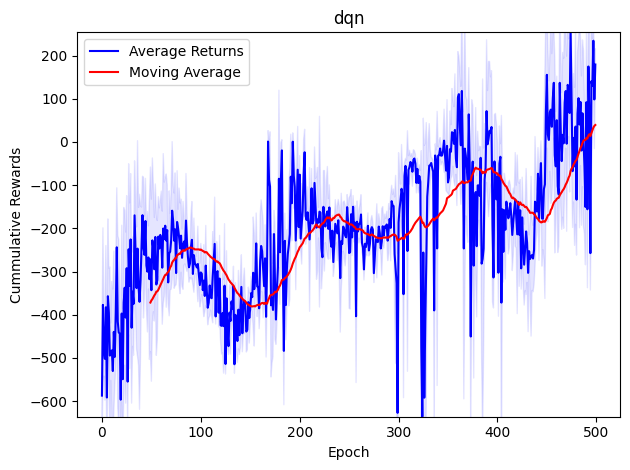

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [27]:
plot_returns(
    mean_returns, std_returns, method_name='dqn'
)

MovieWriter imagemagick unavailable; using Pillow instead.


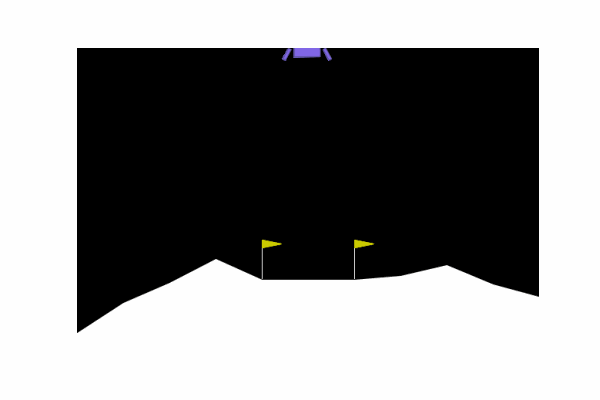

In [28]:
frames = demo_policy(
    Q, ENVIRONMENT_NAME
)
gif_path = save_frames_as_gif(frames, method_name='dqn')
Image(open(gif_path,'rb').read())

***

## 4. Actor-Critic

In [58]:
from src.networks import Policy
from src.networks import ValueFunctionQ
from src.ac import train_one_epoch as ac_epoch

################################## Hyper-parameters Tuning ##################################

EPOCHS: int = 1000
HIDDEN_DIMENSION: int = 128
LEARNING_RATE: float = 1e-4

#############################################################################################

# instantiate the state-action value function, Q
Q = ValueFunctionQ(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION
).to(DEVICE)
# initialize the target network
target_Q = ValueFunctionQ(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION
).to(DEVICE)
# initialize the policy network
policy = Policy(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION
).to(DEVICE)

# Learn the policy and Q
optimizer_Q = Adam(Q.parameters(), lr=LEARNING_RATE)
optimizer_pi = Adam(policy.parameters(), lr=LEARNING_RATE)

memory.clear()
mean_returns, std_returns = [], []
for epoch in range(EPOCHS):

    # copy target network params
    target_Q.load_state_dict(Q.state_dict())
    
    ac_epoch(
        env=environment,
        policy=policy, Q=Q, target_Q=target_Q,
        memory=memory, optimizer_Q=optimizer_Q, optimizer_pi=optimizer_pi,
    )
    
    episode_return_mean, episode_return_std = eval_policy(policy, ENVIRONMENT_NAME)
    mean_returns.append(episode_return_mean)
    std_returns.append(episode_return_std)
    
    logger.info(f'Epoch: {epoch:3d} \t return: {episode_return_mean:.2f}')

    if epoch:
        plot_returns(
            mean_returns, std_returns, method_name='ac', dynamic=True
        )

<Figure size 640x480 with 0 Axes>

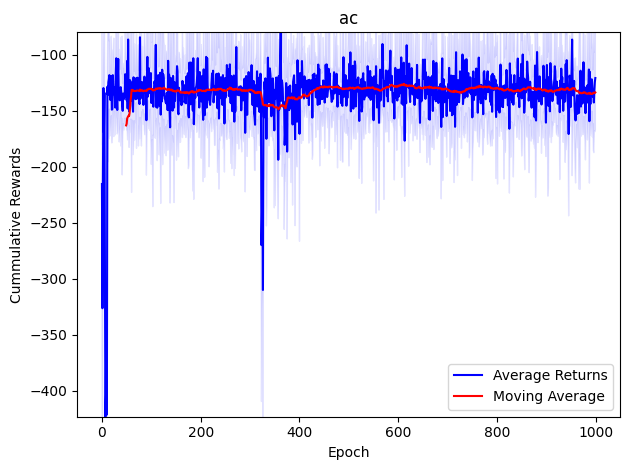

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [59]:
plot_returns(
    mean_returns, std_returns, method_name='ac'
)

MovieWriter imagemagick unavailable; using Pillow instead.


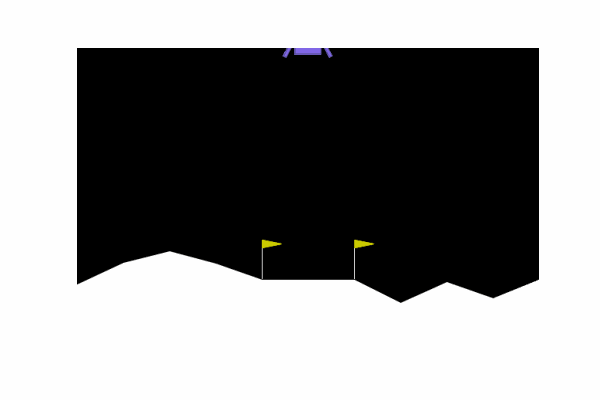

In [60]:
frames = demo_policy(
    policy, ENVIRONMENT_NAME,
)
gif_path = save_frames_as_gif(frames, method_name='ac')
Image(open(gif_path,'rb').read())

***